# Data split for the 4-fold CV

---

This notebook can be used to generate data splits for the screening data to allow for parallel computing of the screens.

---

## 0. Environmental setup

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import os
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from joblib import Parallel, delayed
import yaml

---
## 1. Read in data

To start we will read in the whole metadata set.

In [5]:
processedDir='/data/xinyi/image2reg/data_new/experiments/jump/images/preprocessing/'

In [2]:
md = pd.read_csv(
    os.path.join(processedDir,"full_pipeline/20241018_015541/padded_nuclei_metadata_fileExists.csv.gz"),
    index_col=0,
)
md.head()

,source,batch,plate,well,site,image_file,gene_symbol,bb_width,bb_height,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1
0,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,34,21,18.152311,36.641606,0.495402,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,29.588694,207.678363
1,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,24,32,20.726421,33.983415,0.609898,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,42.947177,1229.174863
2,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,32,39,28.960515,41.599552,0.696174,1,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,80.714286,1196.022222
3,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,22,35,22.335351,35.301121,0.632709,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,87.434572,1124.943457
4,source_13,20220914_Run1,CP-CC9-R1-03,N22,1,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,ALOX5,29,52,25.967213,55.164771,0.470721,0,151,source_13_20220914_Run1_CP-CC9-R1-03_N22_1_ALO...,NaN,92.285843,189.496844


In [3]:
batches = np.unique(md.loc[:, "batch"])

batches

array(['20220914_Run1', '20221009_Run2', '20221017_Run3', '20221024_Run4',
       '20221109_Run5', '20221120_Run6'], dtype=object)

In [38]:
output_dir = os.path.join(processedDir,"screen_splits_impactful")
os.makedirs(output_dir)

In [39]:
label_col = "gene_symbol"
group_col = "batch"
n_folds = 5
holdout=batches[:5]

In [67]:
def get_separation(label):
    if label=='NC':
        return
    label_output_dir = os.path.join(output_dir, label)
    if not os.path.exists(label_output_dir):
        os.makedirs(label_output_dir)
    labelIdx=np.logical_or(labels_all==label,labels_all=='NC')
    for k in range(n_folds):
        print(k)
        testBatch=holdout[k]
        testbatchIdx=md.loc[:, 'batch']==testBatch
        if np.sum(testbatchIdx)==0:
            continue
        testIdx=np.logical_and(labelIdx,testbatchIdx)
        trainvalIdx=np.logical_and(labelIdx,md.loc[:, 'batch']!=testBatch)
        #test
        # print('test before subsample: ',np.sum(testIdx))
        data_test=md[testIdx]
        idc = np.arange(data_test.shape[0]).reshape(-1, 1)
        labels = data_test.loc[:, label_col]
        if np.unique(labels).size<2:
            continue
        idc, _ = RandomUnderSampler(
            sampling_strategy="majority", random_state=random_state
        ).fit_resample(idc, labels)
        # print('test after subsample: ',idc.size)
        data_test = data_test.iloc[idc.flatten(), :]
        data_test.to_csv(os.path.join(label_output_dir, "nuclei_md_test_fold_{}.csv".format(k)))
        
        #train-val
        # print('train-val before subsample: ',np.sum(trainvalIdx))
        data_trainval=md[trainvalIdx]
        idc = np.arange(data_trainval.shape[0]).reshape(-1, 1)
        labels = data_trainval.loc[:, label_col]
        idc, _ = RandomUnderSampler(
            sampling_strategy="majority", random_state=random_state
        ).fit_resample(idc, labels)
        # print('train-val after subsample: ',idc.size)
        data_trainval = data_trainval.iloc[idc.flatten(), :]
        labels=np.array(labels)[idc.flatten()]
        groups_trainval=data_trainval['slide_image_name']
        train_index, val_index = next(
            GroupShuffleSplit(
                test_size=val_size, n_splits=2, random_state=random_state
            ).split(
                data_trainval, labels, groups=groups_trainval
            )
        )
        #train
        data_train = data_trainval.iloc[train_index]
        data_train.to_csv(os.path.join(label_output_dir, "nuclei_md_train_fold_{}.csv".format(k)))

        #val
        data_val = data_trainval.iloc[val_index]
        data_val.to_csv(os.path.join(label_output_dir, "nuclei_md_val_fold_{}.csv".format(k)))

In [69]:
val_size=0.2
# labels_all =np.copy(md.loc[:, label_col])
# labels_all[labels_all=='non-targeting']='NC'
# labels_all[labels_all=='no-guide']='NC'
# md[label_col]=labels_all
# labels=np.unique(labels_all)

Parallel(n_jobs=10)(
    delayed(get_separation)(label)
    for label in tqdm(labels[np.where(labels=='PTN')[0][0]:])
)





  0%|                                                                                                         | 0/38 [00:00<?, ?it/s]



 26%|█████████████████████████▎                                                                      | 10/38 [00:02<00:07,  3.59it/s]



 29%|███████████████████████████▊                                                                    | 11/38 [00:03<00:08,  3.32it/s]



 53%|██████████████████████████████████████████████████▌                                             | 20/38 [06:07<07:30, 25.06s/it]



100%|████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [12:06<00:00, 19.12s/it]


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [68]:
labels=np.unique(labels_all)
for label in tqdm(labels[np.where(labels=='PTCH1')[0][0]:]):
    print(label)
    get_separation(label)





  0%|                                                                                                         | 0/39 [00:00<?, ?it/s]

PTCH1
0
1
2
3
4






  3%|██▍                                                                                           | 1/39 [04:25<2:48:07, 265.46s/it]

PTN
0
1
2


  3%|██▍                                                                                           | 1/39 [07:24<4:41:13, 444.05s/it]


KeyboardInterrupt: 

In [71]:
labels[136]

'TRAF2'

In [70]:
# generate yml files for each label
config_dir='/home/xinyiz/image2reg/config/image_embedding/screen/jump_ko_impactful/'
template_path=os.path.join(config_dir,'train_resnet_ctrl_vs_gene_template.yml')

for i in range(n_folds):
    print(i)
    config_dir_i=os.path.join(config_dir,'fold_'+str(i))
    if not os.path.exists(config_dir_i):
        os.mkdir(config_dir_i)
    for label in labels[np.where(labels=='PTN')[0][0]:]:
        if label=='NC':
            continue
        if not os.path.exists('/data/xinyi/image2reg/data_new/experiments/jump/images/preprocessing/screen_splits_impactful/'+label+'/nuclei_md_test_fold_{}.csv'.format(i)):
            continue
        with open(template_path, 'r') as file:
            template = yaml.safe_load(file)
        template['output_dir']=template['output_dir'].format(i)
        data_config= template['run_params']['data_config']
        data_config['train_nuclei_metadata_file']=data_config['train_nuclei_metadata_file'].format(label,i)
        data_config['val_nuclei_metadata_file']=data_config['val_nuclei_metadata_file'].format(label,i)
        data_config['test_nuclei_metadata_file']=data_config['test_nuclei_metadata_file'].format(label,i)
        template['run_params']['data_config']=data_config
        with open(os.path.join(config_dir_i,label+'.yml'), 'w') as file:
            yaml.safe_dump(template, file, default_flow_style=False,sort_keys=False)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


---

## 2. StratifiedGrouped K-Fold

We will now go over each individual gene and add a column to the dataframe that indicates to which fold of the respective gene screen the respective nuclei corresponds to. Thereby, we will ensure that all nuclei from the same slide-image are in the same fold to ensure that the model cannot cheat by focussing on imaging artifacts specific to individual slide images.

In [8]:
output_dir = "../../../data/experiments/jump/images/preprocessing/specific_targets_cv_stratified/"
os.makedirs(output_dir, exist_ok=True)

In [9]:
label_col = "gene_symbol"
group_col = "slide_image_name"
random_state = 1234
n_folds = 4

In [10]:
target_list = sorted(list(spec_orf_targets) + ["EMPTY"])
print(target_list)
fold_data = get_data_splits_for_label(
    data=md,
    label_col=label_col,
    target_list=target_list,
    n_folds=n_folds,
    group_col=group_col,
    random_state=random_state,
)
for k, v in fold_data.items():
    for i in range(len(v)):
        fold_label_data = fold_data[k][i].to_csv(
            os.path.join(output_dir, "nuclei_md_{}_fold_{}.csv".format(k, i))
        )

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']
{'CREB1': 4877, 'ELK1': 3369, 'EMPTY': 15378, 'ERG': 3798, 'SMAD4': 3124, 'TSC2': 4552, 'WWTR1': 4497, 'RHOA': 10323, 'BCL2L11': 1823, 'IRAK4': 10581, 'CDKN1A': 7355, 'RAF1': 10351, 'SRC': 9320, 'MAP3K9': 8104, 'FGFR3': 4388, 'PIK3R2': 10434, 'BAX': 5048, 'MYD88': 5623, 'AKT1S1': 6223, 'ATF4': 8957, 'DIABLO': 5349, 'SREBF1': 5237, 'TRAF2': 6571, 'JUN': 5628, 'CASP8': 1029, 'HRAS': 3729, 'PRKACA': 12576, 'PRKCE': 15378, 'RELB': 5361, 'BRAF': 11687, 'MAP3K2': 7477, 'MAP3K5': 8276}


In [11]:
len(set(fold_data["test"][0].gene_symbol))

32

<AxesSubplot:>

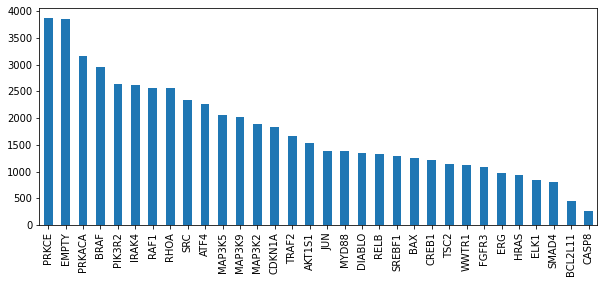

In [12]:
fold_data["test"][0].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

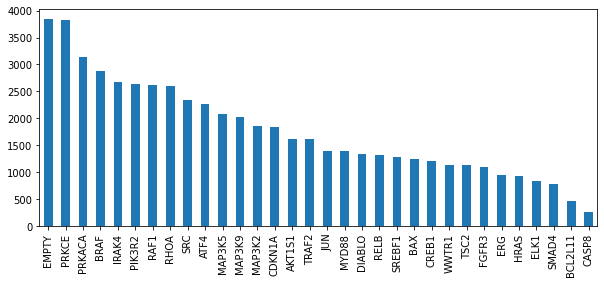

In [13]:
fold_data["test"][1].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

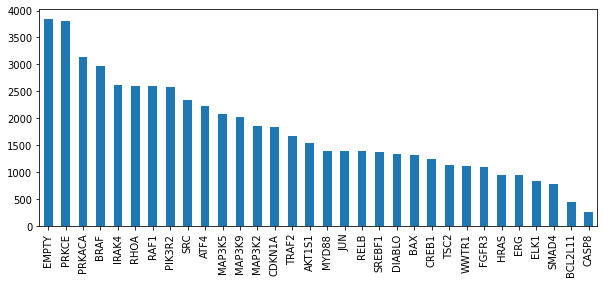

In [14]:
fold_data["test"][2].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

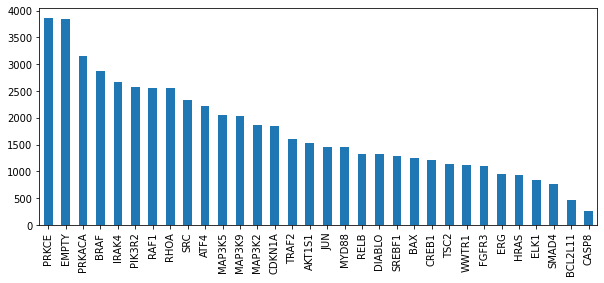

In [15]:
fold_data["test"][3].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))